In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import warnings

import geopandas as gpd
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo
from sqlalchemy import text

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(admin=True)

Username:  ········
Password:  ········


Connection successful.


# TEOTIL3: Annual data tidying 2023/4

Notebook `T2-1d_annual_data_upload.ipynb` performs the main steps required to upload data each year. However, the structure of the data delivered changes a little from year to year, so some custom cleaning/tidying is usually required. This notebook performs basic tidying to generate cleaned input files, which can then be used with `T2-1d_annual_data_upload.ipynb`.

In [4]:
# Data are being uploaded for 'data_year'
data_year = 2023

# 'admin_year' is usually the current year (i.e. 'data_year' + 1).
# It's also the year for which new admin. boundaries will be added.
admin_year = data_year + 1

In [5]:
# Create folder for point data
pt_data_fold = f"/home/jovyan/shared/common/teotil3/point_data/{data_year}"
if not os.path.exists(pt_data_fold):
    os.makedirs(pt_data_fold)

## 1. Update administrative boundaries

 1. Download the latest kommune boundaries for the current year from [GeoNorge](https://www.geonorge.no/). Choose UTM Zone 33N as the CRS and FGDB as the format. (The fylke boundaries are derived by dissolving the kommune dataset, so it is not necessary to download the fylke dataset as well).
    
 2. Rename the FGDB `kommuner{year}.gdb`. Zip it, upload to `/home/jovyan/shared/common/teotil3/core_data/administrative/raw`, unzip, and delete the zip archive.

 3. Run the code cell below to process the new administrative data and assign it to regines. **Note that the NIBIO regines are hard-code below (`nib_gpkg`)**.
 
 4. Run the next code cell to update PostGIS.

In [6]:
# Process admin. boundaries
admin_data_fold = r"/home/jovyan/shared/common/teotil3/core_data/administrative"
admin_gpkg = os.path.join(admin_data_fold, "admin_data.gpkg")
gdb_path = os.path.join(admin_data_fold, "raw", f"kommuner{admin_year}.gdb")
gdf = gpd.read_file(gdb_path, layer="kommune")

# Get fylkesnummer from kommnr
gdf.rename({"kommunenummer": "komnr"}, axis="columns", inplace=True)
gdf["komnr"] = gdf["komnr"].astype(str)
gdf["fylnr"] = gdf["komnr"].str[:2]
gdf = gdf[["fylnr", "komnr", "geometry"]]

# Dissolve
kom_gdf = gdf.dissolve(by="komnr", aggfunc="first").reset_index()
kom_gdf = kom_gdf[["fylnr", "komnr", "geometry"]]
fyl_gdf = gdf.dissolve(by="fylnr").reset_index()
fyl_gdf = fyl_gdf[["fylnr", "geometry"]]

# Save
kom_gdf.to_file(
    admin_gpkg,
    driver="GPKG",
    layer=f"kommuner{admin_year}",
    index=False,
)
fyl_gdf.to_file(
    admin_gpkg,
    driver="GPKG",
    layer=f"fylker{admin_year}",
    index=False,
)

# Assign to regines
nib_gpkg = r"/home/jovyan/shared/common/teotil3/core_data/hydrology/nibio_regines.gpkg"
reg_gdf = gpd.read_file(nib_gpkg, layer="RegineEnhetNibio")
reg_gdf = teo.preprocessing.assign_regines_to_administrative_units(
    reg_gdf, admin_gpkg, admin_year
)
reg_gdf.rename(
    {"komnr": f"komnr_{admin_year}", "fylnr": f"fylnr_{admin_year}"},
    axis="columns",
    inplace=True,
)
reg_gdf = reg_gdf[["regine", f"komnr_{admin_year}", f"fylnr_{admin_year}"]]
assert reg_gdf.isna().sum().sum() == 0

Processing kommuner
   357 kommuner.
   23931 regines.
   31383 intersected polygons.
   23648 regines assigned to kommuner.
Processing fylker
   15 fylker.
   23931 regines.
   24833 intersected polygons.
   23648 regines assigned to fylker.


In [7]:
# # Write to temp table
# reg_gdf.to_sql(
#     "temp",
#     eng,
#     schema="teotil3",
#     index=False,
#     if_exists="replace",
# )

# # Extend existing table with new info
# with eng.connect() as connection:
#     with connection.begin() as transaction:
#         # Add new columns
#         sql = text(
#             f"ALTER TABLE teotil3.regines "
#             f"ADD COLUMN komnr_{admin_year} text, "
#             f"ADD COLUMN fylnr_{admin_year} text"
#         )
#         connection.execute(sql)

#         # Update with data from temporary table
#         sql = text(
#             f"UPDATE teotil3.regines "
#             f"SET komnr_{admin_year} = temp.komnr_{admin_year}, "
#             f"    fylnr_{admin_year} = temp.fylnr_{admin_year} "
#             f"FROM teotil3.temp temp "
#             f"WHERE teotil3.regines.regine = temp.regine"
#         )
#         connection.execute(sql)

#         # Add NOT NULL constraint
#         sql = text(
#             f"ALTER TABLE teotil3.regines "
#             f"ALTER COLUMN komnr_{admin_year} SET NOT NULL, "
#             f"ALTER COLUMN fylnr_{admin_year} SET NOT NULL"
#         )
#         connection.execute(sql)

#         # Drop the temporary table
#         sql = text("DROP TABLE teotil3.temp")
#         connection.execute(sql)

#         transaction.commit()

## 2. Wastewater data from SSB

### 2.1. Large wastewater sites

#### 2.1.1. Treatment type, BOF and KOF

This file includes the `RENSPRINSIP` for each "large" site, as well as estimates for BOF5 and KOF.

In [8]:
# Read and tidy
fpath = f"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_{admin_year}/RID_Totalpopulasjon_incl_BOF5_KOF_{data_year}.csv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")
df["year"] = data_year
df.rename({"anleggsnavn": "ANLEGGSNAVN"}, axis="columns", inplace=True)
df.dropna(subset=["RENSPRINS", "utslipp_BOF5", "utslipp_KOF"], how="all", inplace=True)

# The naming of some treatment types has changed in this year's data.
# Standardise to match existing names
type_map = {
    "Kjemisk-biologisk uten N-fjerning": "Kjemisk-biologisk",
    "Kjemisk-biologisk med N-fjerning": "Kjemisk-biologisk m/N-fjerning",
}
df['RENSPRINS'] = df['RENSPRINS'].replace(type_map)

df.head()

,KOMMUNE_NR,ANLEGGSNR,ANLEGGSNAVN,KAPASITET1,RENSPRINS,utslipp_BOF5,utslipp_KOF,year
0,3001,0101AL01,Prestebakke,900.0,Biologisk,385.0,2071.0,2023
1,3001,0101AL06,Kornsjø,300.0,Kjemisk-biologisk,221.0,865.0,2023
2,3001,0101AL07,Remmendalen avløpsanlegg,42000.0,Kjemisk-biologisk,49655.0,209539.0,2023
3,3002,0104AL01,Kambo avløpsanlegg,26000.0,Kjemisk,75675.0,205246.0,2023
4,3003,0105AL00,Alvim renseanlegg,60000.0,Kjemisk,322644.0,665745.0,2023


In [9]:
# Save
xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{data_year}/avlop_stor_anlegg_{data_year}_treatment_types_bof_kof.xlsx"
df.to_excel(xl_path, sheet_name="data", index=False)

#### 2.1.2. TOTN and TOTP

This year, Gisle has included outlet co-ordinates, as requested. The BOF5 and KOF data are also in this file - hopefully these are the same as in the `treatment_types` file, but this needs checking.

In [10]:
# Read data
fpath = f"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_{admin_year}/Teotil store anlegg {data_year}.xlsx"
df = pd.read_excel(fpath, skiprows=[0, 2, 3])
df["year"] = data_year
cols = [
    "ANLEGGSNR",
    "ANLEGGSNAVN",
    "Sone",
    "UTM_E",
    "UTM_N",
    "Sone_Utslipp",
    "UTM_E_Utslipp",
    "UTM_N_Utslipp",
    "year",
    "MENGDE_P_INN_kg",
    "MENGDE_P_UT_kg",
    "RENSEEFFEKT_P",
    "MENGDE_N_INN_kg",
    "MENGDE_N_UT_kg",
    "RENSEEFFEKT_N",
    "MENGDE_BOF5_UT_kg",
    "MENGDE_KOF_UT_kg",
]
df = df[cols]
df.dropna(
    subset=[
        "MENGDE_P_UT_kg",
        "MENGDE_N_UT_kg",
        "MENGDE_BOF5_UT_kg",
        "MENGDE_KOF_UT_kg",
    ],
    how="all",
    inplace=True,
)
df.head()

,ANLEGGSNR,ANLEGGSNAVN,Sone,UTM_E,UTM_N,Sone_Utslipp,UTM_E_Utslipp,UTM_N_Utslipp,year,MENGDE_P_INN_kg,MENGDE_P_UT_kg,RENSEEFFEKT_P,MENGDE_N_INN_kg,MENGDE_N_UT_kg,RENSEEFFEKT_N,MENGDE_BOF5_UT_kg,MENGDE_KOF_UT_kg
0,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,32.0,599070.0,6639810.0,32.0,598452.0,6639512.0,2023,200748.79,14810.11,0.93,1620158.62,371749.82,0.77,321343.0,1729099.0
1,0301AL14,"Mariholtet sportsstue, renseanlegg",32.0,606758.0,6640823.0,32.0,606767.0,6640809.0,2023,1.97,0.49,0.75,13.14,10.51,0.20,10.0,32.0
3,0301AL27,Grefsenkollen renseanlegg,32.0,600735.0,6648092.0,32.0,600716.0,6648087.0,2023,0.66,0.07,0.90,4.38,3.50,0.20,5.0,20.0
5,0301AL32,Kikutstua renseanlegg,32.0,592116.0,6661074.0,NaN,NaN,NaN,2023,3.29,0.82,0.75,21.90,17.52,0.20,17.0,53.0
6,0301AL33,Wyllerløypa renseanlegg,32.0,592800.0,6656800.0,32.0,590719.0,6651467.0,2023,2.63,0.13,0.95,17.52,14.58,0.25,4.0,16.0


In [11]:
# Save
xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{data_year}/avlop_stor_anlegg_{data_year}_raw.xlsx"
df.to_excel(xl_path, sheet_name=f"store_anlegg_{data_year}", index=False)

### 2.2. Small wastewater sites

NIBIO have changed the renseeffekter for small sites, so this year Gisle has provided completely new data for small sites from 2022 to present. The entire time series therefore need updating.

In [12]:
# Mapping for SSB codes => TEOTIL3 codes for små anlegg
ssb_csv = "../../data/ssb_sma_anlegg_type_codes.csv"
ssb_df = pd.read_csv(ssb_csv)

# Read data
fpath = f"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_{admin_year}/tmp_teotil_smaa_anlegg_2002_{data_year}.sdv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")
del df["KOMMUNE_NAVN"]
df.rename({"KOMMUNE_NR": "KOMMUNENR", "aargang": "year"}, axis="columns", inplace=True)
df = df.melt(id_vars=["KOMMUNENR", "year"])
df = df[df["variable"].str.startswith(("B", "N", "P"))]
df[["variable", "ssb_code"]] = df["variable"].str.split("_", n=1, expand=True)
code_list = list(ssb_df["ssb_code"].unique())
df = df.query("ssb_code in @code_list")
df.dropna(subset=["value"], inplace=True)
df = pd.merge(df, ssb_df, how="left", on="ssb_code")
df["variable"].replace({"P": "FOSFOR ", "N": "NITROGEN ", "B": "BOF "}, inplace=True)
df["variable"] = df["variable"] + df["teotil_type"]
df.drop(["ssb_code", "ssb_desc", "teotil_type"], inplace=True, axis="columns")
df = df.set_index(["KOMMUNENR", "year", "variable"]).unstack("variable").fillna(0)
df.columns = df.columns.get_level_values(1)
df.reset_index(inplace=True)
df.columns.name = ""
df["KOMMUNENR"] = df["KOMMUNENR"].astype(str).str.zfill(4)

df.head()

,KOMMUNENR,year,BOF Annen løsning,BOF Biologisk,BOF Biologisk og kjemisk,BOF Biologisk toalett,"BOF Biologisk toalett, gråvannsfilter",BOF Direkte utslipp,BOF Infiltrasjonsanlegg,BOF Kjemisk,...,"NITROGEN Biologisk toalett, gråvannsfilter",NITROGEN Direkte utslipp,NITROGEN Infiltrasjonsanlegg,NITROGEN Kjemisk,NITROGEN Konstruert våtmark,NITROGEN Sandfilteranlegg,NITROGEN Slamavskiller,NITROGEN Tett tank (for alt avløpsvann),NITROGEN Tett tank for svartvann,"NITROGEN Tett tank for svartvann, gråvannsfilter"
0,0101,2002,0.0,0.0,1338.0900,0.0,0.0,2803.2,2669.0625,759.3825,...,0.0,560.64,1149.750,271.779,0.0,495.159,6724.176,0.0,1020.6495,1517.39625
1,0101,2003,0.0,0.0,1338.0900,0.0,0.0,2803.2,2669.0625,759.3825,...,0.0,560.64,1149.750,271.779,0.0,495.159,6724.176,0.0,1020.6495,1517.39625
2,0101,2004,0.0,0.0,1338.0900,0.0,0.0,2803.2,2669.0625,759.3825,...,0.0,560.64,1149.750,271.779,0.0,495.159,6724.176,0.0,1020.6495,1517.39625
3,0101,2005,0.0,0.0,1409.2650,0.0,0.0,2715.6,2647.7100,915.4200,...,0.0,543.12,1140.552,327.624,0.0,495.159,6686.727,0.0,1077.5895,392.88600
4,0101,2006,0.0,0.0,1501.7925,0.0,0.0,2452.8,2697.5325,957.0300,...,0.0,490.56,1162.014,342.516,0.0,495.159,6678.405,0.0,1076.1660,394.14525


In [13]:
# Save
years = [year for year in df["year"].unique() if year >= 2013]
for year in years:
    df2 = df.query("year == @year").copy()
    xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/avlop_sma_anlegg_{year}_raw_update2024.xlsx"
    df2.to_excel(xl_path, sheet_name=f"sma_anlegg_{year}", index=False)
    os.remove(xl_path)

In [14]:
for year in range(2013, 2014):
    old_xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/avlop_sma_anlegg_{year}_raw.xlsx"
    new_xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/avlop_sma_anlegg_{year}_raw_update2024.xlsx"

    old_df = pd.read_excel(old_xl_path, sheet_name=f"sma_anlegg_{year}")
    new_df = pd.read_excel(new_xl_path, sheet_name=f"sma_anlegg_{year}")

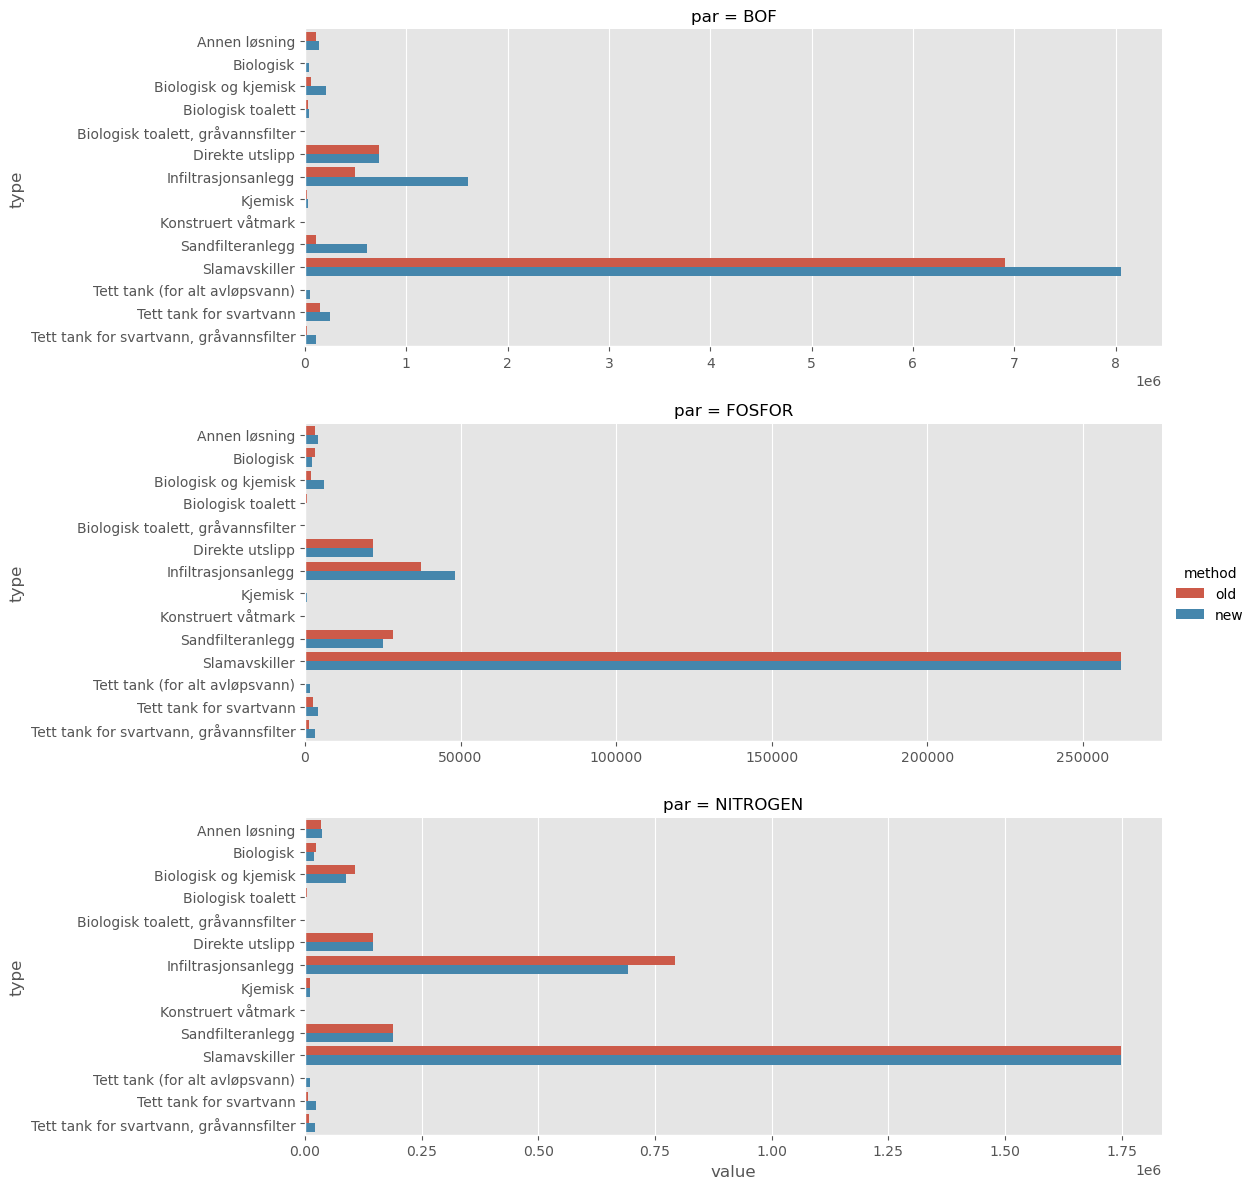

In [15]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.style.use("ggplot")
df = pd.concat(
    [
        old_df.drop(columns=["KOMMUNENR", "year"]).sum(),
        new_df.drop(columns=["KOMMUNENR", "year"]).sum(),
    ],
    axis="columns",
)
df.columns = ["old", "new"]
df[["par", "type"]] = df.index.to_series().str.split(" ", expand=True, n=1)
df = df.reset_index(drop=True)
df = df.melt(id_vars=["par", "type"], var_name="method")
sn.catplot(
    data=df,
    x="value",
    hue="method",
    y="type",
    row="par",
    kind="bar",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
# plt.savefig("small_wastewater_changes_2013.png", dpi=200)

## 3. Industry data from Miljødirektoratet

Now including outlet co-ordinates. The first two rows of the spreadsheet need deleting. There's also a weird blank, half-merged column that needs to be deleted from the original spreadsheet.

In [16]:
# Read data
ind_xl_path = f"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_{admin_year}/glenn_indutsry_data_tidy.xlsx"
df = pd.read_excel(ind_xl_path, sheet_name="Teotiluttrekket til NIVA")

df = df.query("`År` == @data_year")

# Only consider sites NOT connected to the communal network
assert df["Komm. nett"].isna().sum() == 0
df = df[df["Komm. nett"] == False]

del df["CASNr"]
df.dropna(subset=["Mengde"], inplace=True)

df.rename(
    columns={
        "Anlegg Latitude": "Geografisk Latitude",
        "Anlegg Longitude": "Geografisk Longitude",
        "Utslipp Latitude": "Lat_Utslipp",
        "Utslipp Longitude": "Lon_Utslipp",
    },
    inplace=True,
)

# Database contains some exact duplicates. Sum for now
agg_cols = [col for col in df.columns if col != "Mengde"]
df = df.groupby(agg_cols).sum().reset_index()

df.head()

,Anleggsnr,Anleggsnavn,Anleggsaktivitet,Komm. nett,Status,År,Komp. Id,Komp.kode,Komponent,Enhet,Komm.nr,Kommune,Geografisk Longitude,Geografisk Latitude,Lon_Utslipp,Lat_Utslipp,Orgnr,Ansvarlig enhet,NACE,Mengde
0,0301.0234.01,Ekeberg Oljelager,Tanklagring,False,Aktiv,2023,190,OLJE,olje,tonn,301,Oslo,10.760945,59.889866,10.760532,59.880710,884191742,SISTERNE DRIFT DA,52.10,0.730
1,0301.0430.01,Hafslund Celsio AS avd Klemetsrudveien,Avfallsforbrenning,False,Aktiv,2023,45,As,arsen,kg,301,Oslo,10.835762,59.840625,10.835763,59.840622,979594836,HAFSLUND CELSIO AS AVD KLEMETSRUDVEIEN,38.21,0.120
2,0301.0430.01,Hafslund Celsio AS avd Klemetsrudveien,Avfallsforbrenning,False,Aktiv,2023,74,Cd,kadmium,kg,301,Oslo,10.835762,59.840625,10.835763,59.840622,979594836,HAFSLUND CELSIO AS AVD KLEMETSRUDVEIEN,38.21,0.579
3,0301.0430.01,Hafslund Celsio AS avd Klemetsrudveien,Avfallsforbrenning,False,Aktiv,2023,101,Cu,kobber,kg,301,Oslo,10.835762,59.840625,10.835763,59.840622,979594836,HAFSLUND CELSIO AS AVD KLEMETSRUDVEIEN,38.21,0.850
4,0301.0430.01,Hafslund Celsio AS avd Klemetsrudveien,Avfallsforbrenning,False,Aktiv,2023,140,Hg,kvikksølv,kg,301,Oslo,10.835762,59.840625,10.835763,59.840622,979594836,HAFSLUND CELSIO AS AVD KLEMETSRUDVEIEN,38.21,0.057


In [17]:
# Save
xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{data_year}/industri_{data_year}_raw.xlsx"
df.to_excel(xl_path, sheet_name=f"industri_{data_year}", index=False)